## Exercise 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
nodes = ['o', 'a', 'b', 'c', 'd']
node_idx = {n: i for i, n in enumerate(nodes)}
num_nodes = len(nodes)

# Transition matrix Lambda
Lambda = np.zeros((num_nodes, num_nodes))

# o -> a (2/5), o -> b (1/5)
Lambda[node_idx['o'], node_idx['a']] = 0.4
Lambda[node_idx['o'], node_idx['b']] = 0.2

# a -> b (3/4), a -> c (1/4)
Lambda[node_idx['a'], node_idx['b']] = 0.75
Lambda[node_idx['a'], node_idx['c']] = 0.25

# b -> o (1/2), b -> c (1/3)
Lambda[node_idx['b'], node_idx['o']] = 0.5
Lambda[node_idx['b'], node_idx['c']] = 1/3

# c -> b (1/3), c -> d (2/3)
Lambda[node_idx['c'], node_idx['b']] = 1/3
Lambda[node_idx['c'], node_idx['d']] = 2/3

# d -> a (1/3), d -> c (1/3)
Lambda[node_idx['d'], node_idx['a']] = 1/3
Lambda[node_idx['d'], node_idx['c']] = 1/3

# omega contains the rate of total exit for each node
omega = np.sum(Lambda, axis=1)
omega_star = np.max(omega)  # max exit rate for global uniformization

# Local jump probability matrix
P = np.linalg.inv(np.diag(omega)) @ Lambda

# solve for stationary distribution pi:  pi * P = pi
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
# local stationary distribution
pi = pi/np.sum(pi)

# Global jump probability matrix (uniformization)
P_bar = np.zeros_like(Lambda)
P_bar = Lambda / omega_star
for i in range(num_nodes):
    P_bar[i, i] = 1.0 - np.sum(P_bar[i, :])

# global stationary distribution
pi_bar = (pi / omega) / np.sum(pi / omega)

print("Exit rates (omega):", dict(zip(nodes, np.round(omega, 3))))
print("Stationary distribution (pi):", dict(zip(nodes, np.round(pi, 3))))
print("Stationary distribution (pi_bar):", dict(zip(nodes, np.round(pi_bar, 3))))
expected_return_a = 1 / (pi_bar[node_idx['a']] * omega[node_idx['a']]) # Kac's formula for continuous-time
print(f"Theoretical expected return time for 'a': {expected_return_a:.4f}")

Exit rates (omega): {'o': np.float64(0.6), 'a': np.float64(1.0), 'b': np.float64(0.833), 'c': np.float64(1.0), 'd': np.float64(0.667)}
Stationary distribution (pi): {'o': np.float64(0.162), 'a': np.float64(0.185), 'b': np.float64(0.269), 'c': np.float64(0.231), 'd': np.float64(0.154)}
Stationary distribution (pi_bar): {'o': np.float64(0.217), 'a': np.float64(0.149), 'b': np.float64(0.261), 'c': np.float64(0.186), 'd': np.float64(0.186)}
Theoretical expected return time for 'a': 6.7083


In [11]:
# Particle perspective simulation

def simulate_particle_return_time(start_node_idx, n_particles):

    return_times = []

    # since particles do not interact, we can simulate them independently, statistically the results will be the same
    for _ in range(n_particles * 10000):
        current_node = start_node_idx
        time_elapsed = 0.0
        
        while True:
            # local clock
            rate = omega[current_node]
            dt = np.random.exponential(1/rate) # equivalent to -np.log(np.random.rand()) / rate
            time_elapsed += dt
            
            next_node = np.random.choice(num_nodes, p=P[current_node]) # local jump matrix
            
            current_node = next_node
            
            
            if current_node == start_node_idx:
                return_times.append(time_elapsed)
                break
                
    return np.array(return_times)

N_particles = 100
return_times = simulate_particle_return_time(node_idx['a'], N_particles)
avg_return_time = np.mean(return_times)
print(f"Number of particles: {N_particles}")
print(f"Average return time simulated (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Comparison with theoretical ({expected_return_a:.4f}): {'Close' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distant'}")


Number of particles: 100
Average return time simulated (start a -> ... -> a): 6.7014
Comparison with theoretical (6.7083): Close


In [12]:
def simulate_particles_system_wide_clock(N_particles, start_node_label):
    start_idx = node_idx[start_node_label]
    
    # system state: positions of all particles
    positions = np.full(N_particles, start_idx, dtype=int)
    
    # the particle has left the starting node
    has_left = np.full(N_particles, False, dtype=bool)
    
    # the particle has returned
    finished = np.full(N_particles, False, dtype=bool)
    
    return_times = np.zeros(N_particles)
    
    current_time = 0.0
    count_finished = 0
    
    # global clock
    global_rate = N_particles * omega_star
    
    while count_finished < N_particles:
        
        dt = np.random.exponential(1 / global_rate)
        current_time += dt
        
        # randomly select a particle to move
        # a particle could be selected even if it has finished in order to not alter the system, but it won't affect the return time
        p_idx = np.random.randint(0, N_particles)
        
        curr_node = positions[p_idx]
        
        # jump based on global jump matrix
        next_node = np.random.choice(num_nodes, p=P_bar[curr_node])
        
        positions[p_idx] = next_node
        
        if not finished[p_idx]:
            
            # left if no self-jump
            if curr_node == start_idx and next_node != start_idx:
                has_left[p_idx] = True
            
            # check if returned to start and has left
            if next_node == start_idx and has_left[p_idx]:
                return_times[p_idx] = current_time
                finished[p_idx] = True
                count_finished += 1

    return return_times

N_particles = 100
return_times = [np.mean(simulate_particles_system_wide_clock(N_particles, 'a')) for _ in range(10000)]
avg_return_time = np.mean(return_times)
print(f"Number of particles: {N_particles}")
print(f"Average return time simulated (start a -> ... -> a): {avg_return_time:.4f}")
print(f"Comparison with theoretical ({expected_return_a:.4f}): {'Close' if abs(avg_return_time - expected_return_a) < 1.0 else 'Distant'}")

Number of particles: 100
Average return time simulated (start a -> ... -> a): 6.7054
Comparison with theoretical (6.7083): Close


In [13]:
# Node perspective simulation
def simulate_node_perspective(start_dist, total_time, n_particles=100, method='uniformization'):

    counts = np.array(start_dist, dtype=int)
    current_time = 0.0
    
    # plotting variables
    times = [0.0]
    history = [counts.copy()]

    if method == 'uniformization':
        # global Poisson clock rate
        total_system_rate = n_particles * omega_star
    
    while True:
        
        if method == 'gillespie':
            node_rates = counts * omega
            total_system_rate = np.sum(node_rates) # trick? if i want a clock for each node ?
            
        # time to next event (global exponential)
        dt = np.random.exponential(1 / total_system_rate)
        current_time += dt
        
        if current_time > total_time:
            break

        # choose which node moves a particle (proportional to particles number)
        if method == 'gillespie':
            source_node = np.random.choice(num_nodes, p=node_rates/np.sum(node_rates)) # check choice source node (trick?)
            # use P to choose where the particle jumps
            target_node = np.random.choice(num_nodes, p=P[source_node])
        
        if method == 'uniformization':
            source_node = np.random.choice(num_nodes, p=counts/n_particles)
            # use P_bar to choose where the particle jumps
            target_node = np.random.choice(num_nodes, p=P_bar[source_node])
        
        # update states
        counts[source_node] -= 1
        counts[target_node] += 1
        
        times.append(current_time)
        history.append(counts.copy())
        
    return np.array(times), np.array(history)

initial_counts = [0, 100, 0, 0, 0] # every particle starts in 'a'
T_max = 60
times, history = simulate_node_perspective(initial_counts, T_max, N_particles, method='uniformization')
times_l, history_l = simulate_node_perspective(initial_counts, T_max, N_particles, method='gillespie')

final_counts = history[-1]
final_counts_l = history_l[-1]
expected_counts = pi_bar * 100 # TODO check meaning pi_bar (time each particle spends in each node at stationarity or number of particles at each node at stationarity?)
expected_counts_l = pi * 100

Simulated final counts global clock (t=60):
{'o': np.int64(22), 'a': np.int64(15), 'b': np.int64(32), 'c': np.int64(18), 'd': np.int64(13)}
Theoretical stationary expected counts (N * pi_bar):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}
Time Average Counts
{'o': np.float64(21.0), 'a': np.float64(16.0), 'b': np.float64(27.0), 'c': np.float64(17.0), 'd': np.float64(19.0)}


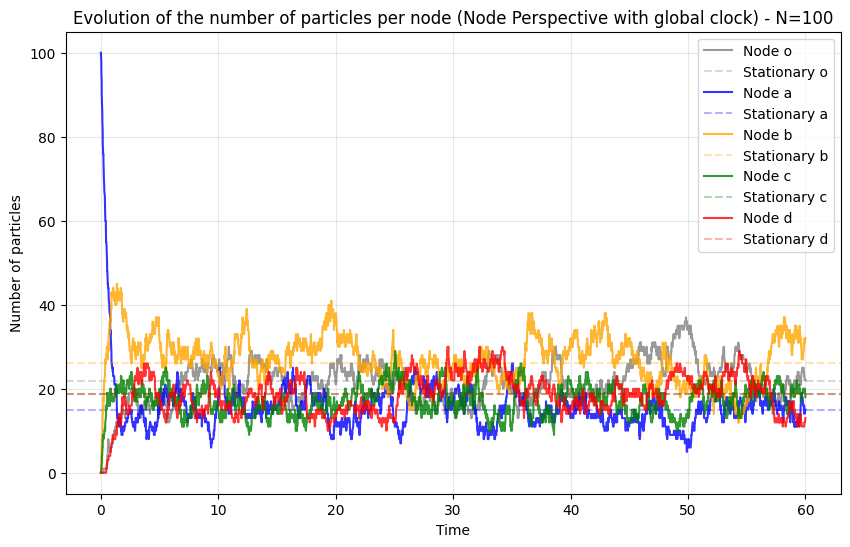

In [14]:
print(f"Simulated final counts global clock (t={T_max}):")
print(dict(zip(nodes, final_counts)))
print("Theoretical stationary expected counts (N * pi_bar):")
print(dict(zip(nodes, np.round(expected_counts, 1))))


history_arr = np.array(history)

# time average count (without initial transient)
time_averaged_counts = np.mean(history_arr[10:], axis=0) # discard first 10 steps of transient

print("Time Average Counts")
print(dict(zip(nodes, np.round(time_averaged_counts, 0))))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times, history[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')


plt.title(f'Evolution of the number of particles per node (Node Perspective with global clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_global_clock.pdf')
plt.show()

Simulated final counts local clock (t=60):
{'o': np.int64(20), 'a': np.int64(13), 'b': np.int64(27), 'c': np.int64(22), 'd': np.int64(18)}
Theoretical stationary expected counts (N * pi):
{'o': np.float64(21.7), 'a': np.float64(14.9), 'b': np.float64(26.1), 'c': np.float64(18.6), 'd': np.float64(18.6)}
Time Average Counts
{'o': np.float64(21.0), 'a': np.float64(16.0), 'b': np.float64(26.0), 'c': np.float64(19.0), 'd': np.float64(18.0)}


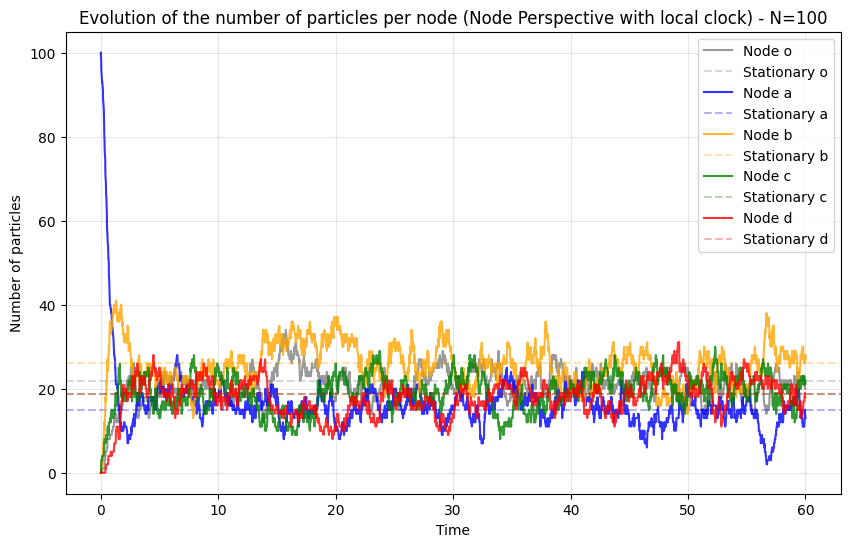

In [15]:
print(f"Simulated final counts local clock (t={T_max}):")
print(dict(zip(nodes, final_counts_l)))
print("Theoretical stationary expected counts (N * pi):")
print(dict(zip(nodes, np.round(expected_counts, 1))))


history_arr = np.array(history_l)

# time average count (without initial transient)
time_averaged_counts = np.mean(history_arr[10:], axis=0) # discard first 10 steps of transient

print("Time Average Counts")
print(dict(zip(nodes, np.round(time_averaged_counts, 0))))

plt.figure(figsize=(10, 6))
colors = ['gray', 'blue', 'orange', 'green', 'red']
for i in range(num_nodes):
    plt.plot(times_l, history_l[:, i], label=f'Node {nodes[i]}', color=colors[i], alpha=0.8)
    plt.axhline(y=expected_counts[i], color=colors[i], linestyle='--', alpha=0.3, label=f'Stationary {nodes[i]}')


plt.title(f'Evolution of the number of particles per node (Node Perspective with local clock) - N={sum(initial_counts)}')
plt.xlabel('Time')
plt.ylabel('Number of particles')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.savefig('node_perspective_simulation_local_clock.pdf')
plt.show()

In [16]:
print(len(times))
print(len(times_l))

6146
4958
